## Intrusion Detection Systems (IDS) research baseline

### 1. Environment Setup + Library import

In [ ]:
'''
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
'''

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
sys.path.append('../scripts')
from ensemble_model import get_stacking_model
from lightweight_hybrid_sdn_model import get_lightweight_hybrid_sdn_model
import joblib

### 2. Data cleaning and preprocessing  

2.1 Load and Review the Dataset + Feature Selection

In [2]:
df = pd.read_csv('../../dataset/SDN_IoT-Dataset/10-iot/35000_each.csv')

print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   srcMAC             210000 non-null  object 
 1   dstMAC             210000 non-null  object 
 2   srcIP              210000 non-null  object 
 3   dstIP              210000 non-null  object 
 4   srcPort            204165 non-null  float64
 5   dstPort            204165 non-null  float64
 6   last_seen          210000 non-null  float64
 7   Protocol           210000 non-null  object 
 8   proto_number       210000 non-null  float64
 9   Dur                210000 non-null  float64
 10  Mean               210000 non-null  float64
 11  Stddev             210000 non-null  float64
 12  Min                210000 non-null  float64
 13  Max                210000 non-null  float64
 14  Pkts               210000 non-null  float64
 15  Bytes              210000 non-null  float64
 16  Sp

In [3]:
''' 
Keep these types of features:

1. Source/Destination Ports: Indicative of specific services.
2. Duration, Packet Count, Byte Count: Useful for traffic behavior analysis.
3. Protocol: Essential for distinguishing between TCP/UDP traffic.
4. Attack and Category Labels: The target for model.
'''

df.drop(['srcMAC', 'dstMAC', 'srcIP', 'dstIP'], axis=1, inplace=True)

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values[missing_values > 0]}")

Missing values per column:
srcPort    5835
dstPort    5835
dtype: int64


2.2 Handling Missing Values + Convert Data Types

In [5]:
# Impute missing values for 'srcPort' and 'dstPort' using the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
df[['srcPort', 'dstPort']] = imputer.fit_transform(df[['srcPort', 'dstPort']])
df_imputed = df.copy()

In [6]:
df_imputed['srcPort'] = df_imputed['srcPort'].astype(int)
df_imputed['dstPort'] = df_imputed['dstPort'].astype(int)
df_imputed['Dur'] = df_imputed['Dur'].astype(float)
df_imputed['Protocol'] = df_imputed['Protocol'].astype('category')
df_imputed['Attack'] = df_imputed['Attack'].astype('category')
df_imputed['Category'] = df_imputed['Category'].astype('category')

2.3 Feature Engineering

In [7]:
"""Apply feature engineering steps like scaling, encoding, etc."""

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# One-hot encoding for categorical features (like Protocol)
ohe = OneHotEncoder(sparse=False, drop='first')

# Standardization
# scaler = StandardScaler()
# scaler = MinMaxScaler()
scaler = RobustScaler()

# ColumnTransformer to apply transformations to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', ohe, cat_cols)
    ]
)


# Apply the transformations
df_preprocessed = preprocessor.fit_transform(df)

# Convert back to DataFrame with proper column names
df_encoded = pd.DataFrame(df_preprocessed, columns=num_cols.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist())

c:\GW\SDN_IOT\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.01)
outliers = iso_forest.fit_predict(df_encoded)

# Remove outliers
df_cleaned = df_encoded[outliers != -1]

# # Save cleaned data
# df_cleaned.to_csv('dataset/cleaned_dataset.csv', index=False)

c:\GW\SDN_IOT\venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
# Load cleaned data
df = pd.read_csv('dataset/cleaned_dataset.csv')

In [9]:
# Classification type: 'binary' or 'multi-class'
classification_type = 'binary' 
# Train-test split
X = df_cleaned.drop(['Attack', 'Category'], axis=1)
if classification_type == 'binary':
    y = df_cleaned['Attack']  
else:
    y = df_cleaned['Category'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3. Data visualization

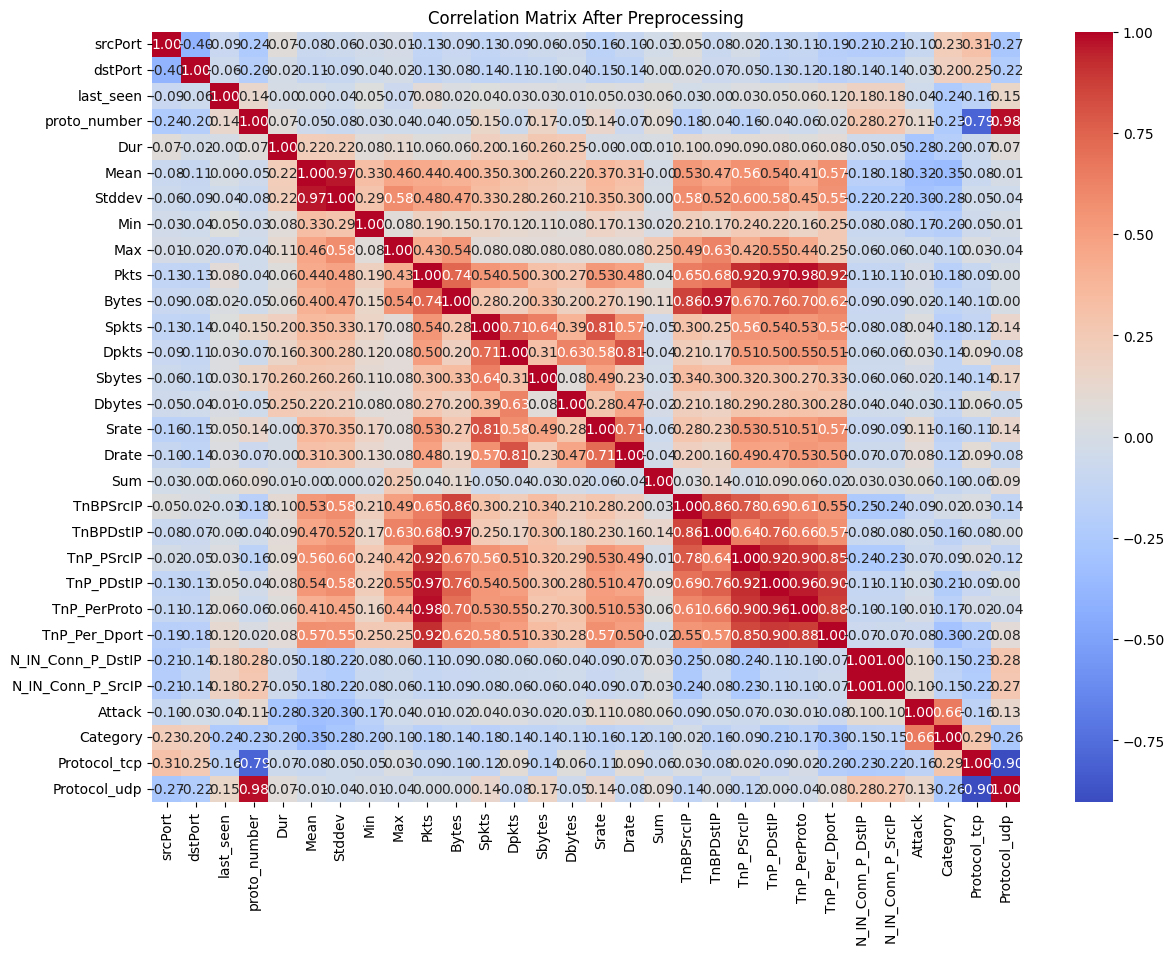

In [25]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix After Preprocessing')
plt.show()

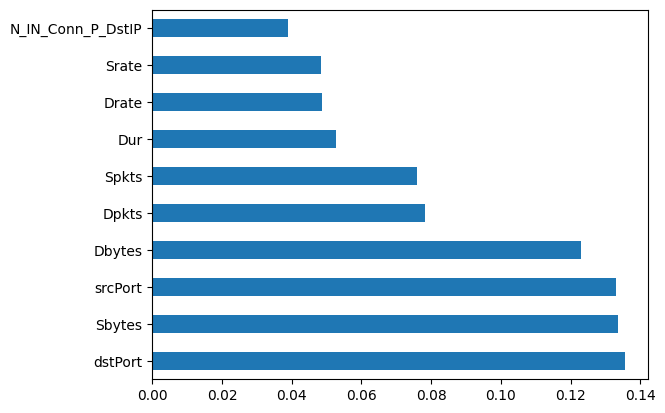

In [26]:
# Feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [10]:
# Handling Class Imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# # Feature Selection
# from sklearn.feature_selection import RFE
# selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)
# X_train_res = selector.fit_transform(X_train_res, y_train_res)
# X_test = selector.transform(X_test)

### 4. Model build & Training

In [11]:
model = get_lightweight_hybrid_sdn_model(X_train_res, y_train_res, classification_type='binary')
model.fit(X_train_res, y_train_res)

Pipeline(steps=[('feature_extractor',
                 <lightweight_hybrid_sdn_model.SimpleDecisionTreeFeatureExtractor object at 0x0000017B263A97E0>),
                ('classifier',
                 MLPClassifier(alpha=0.001, hidden_layer_sizes=(20,),
                               max_iter=300, random_state=42))])

In [33]:
# Get the ensemble model
# model = get_stacking_model(X_train_res, y_train_res)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

In [12]:
# Predictions
y_pred = model.predict(X_test)

In [ ]:
# Save the model
joblib.dump(model, 'models/ensemble_model.pkl')

### 6. Evaluation

In [ ]:
# Load model
model = joblib.load('models/ensemble_model.pkl')

Accuracy:  0.9243867243867244
              precision    recall  f1-score   support

        -1.0       0.73      0.85      0.79     10288
         0.0       0.97      0.94      0.95     52082

    accuracy                           0.92     62370
   macro avg       0.85      0.89      0.87     62370
weighted avg       0.93      0.92      0.93     62370



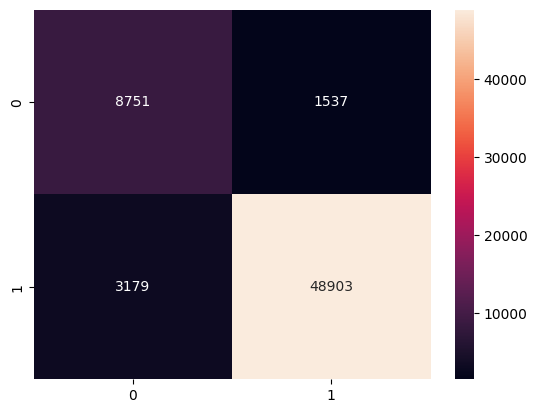

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Model Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()

c:\GW\SDN_IOT\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\GW\SDN_IOT\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\GW\SDN_IOT\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\GW\SDN_IOT\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


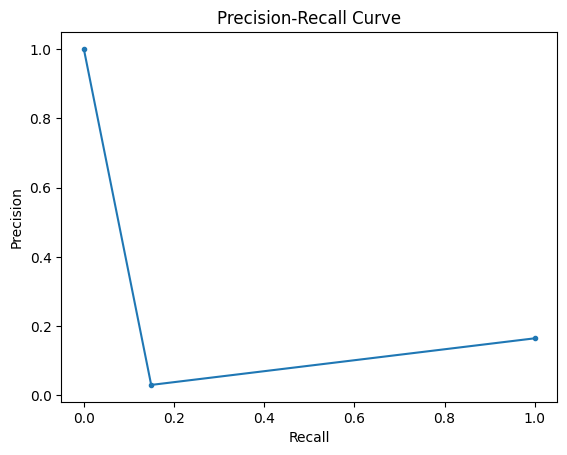

Matthews Correlation Coefficient: 0.74505620655209


In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, matthews_corrcoef

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)
cross_val_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

# Precision-Recall AUC specifying pos_label
precision, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=-1.0)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")
